In [5]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator, DeepSpeedPlugin

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder, FrozenOpenCLIPEmbedder2
from generative_models.sgm.models.diffusion import DiffusionEngine
from generative_models.sgm.util import append_dims
from omegaconf import OmegaConf

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils
from models import *

### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
device = accelerator.device
print("device:",device)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


LOCAL RANK  0
device: cuda


In [6]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "pretrained_subj09irf_40sess_hypatia_imageryrf_imagery_no_blurry"
    print("model_name:", model_name)

    # global_batch_size and batch_size should already be defined in the above cells
    # other variables can be specified in the following string:
    jupyter_args = f"--data_path=/ps6938/shared/mindeyev2_dataset \
                    --model_name={model_name} --subj=9 \
                    --no-blurry_recon \
                    --hidden_dim=1024 --n_blocks=4 --new_test"
    
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: pretrained_subj09irf_40sess_hypatia_imageryrf_imagery_no_blurry
--data_path=/ps6938/shared/mindeyev2_dataset                     --model_name=pretrained_subj09irf_40sess_hypatia_imageryrf_imagery_no_blurry --subj=9                     --no-blurry_recon                     --hidden_dim=1024 --n_blocks=4 --new_test
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="will load ckpt for model found in ../train_logs/model_name",
)
parser.add_argument(
    "--data_path", type=str, default="/weka/proj-fmri/shared/mindeyev2_dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8,9,10,11],
    help="Validate on which subject?",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--clip_scale",type=float,default=1.,
)
parser.add_argument(
    "--n_blocks",type=int,default=4,
)
parser.add_argument(
    "--hidden_dim",type=int,default=2048,
)
parser.add_argument(
    "--new_test",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--seq_len",type=int,default=1,
)
parser.add_argument(
    "--seed",type=int,default=42,
)
if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)

# make output directory
os.makedirs("evals",exist_ok=True)
os.makedirs(f"evals/{model_name}",exist_ok=True)

In [8]:
voxels = {}
# Load hdf5 data for betas
f = h5py.File(f'{data_path}/betas_all_subj0{subj}_fp32_renorm.hdf5', 'r')
# f = h5py.File(f'{data_path}/betas_3point6mm_subj01.hdf5', 'r')
betas = f['betas'][:]
betas = torch.Tensor(betas).to("cpu")
num_voxels = betas[0].shape[-1]
voxels[f'subj0{subj}'] = betas
print(f"num_voxels for subj0{subj}: {num_voxels}")

if not new_test: # using old test set from before full dataset released (used in original MindEye paper)
    if subj==3:
        num_test=2113
    elif subj==4:
        num_test=1985
    elif subj==6:
        num_test=2113
    elif subj==8:
        num_test=1985
    else:
        num_test=2770
    test_url = f"{data_path}/wds/subj0{subj}/test/" + "0.tar"
else: # using larger test set from after full dataset released
    if subj==3:
        num_test=2371
    elif subj==4:
        num_test=2188
    elif subj==6:
        num_test=2371
    elif subj==8:
        num_test=2188
    else:
        num_test=3000
    test_url = f"{data_path}/wds/subj0{subj}/new_test/" + "0.tar"
    
nsessions_allsubj=np.array([40, 40, 32, 30, 40, 32, 40, 30])
from braceexpand import braceexpand
test_url = [test_url] + list(braceexpand(f"{data_path}/wds/subj0{subj}/train/" + "{0.." + f"{nsessions_allsubj[subj-1]-1}" + "}.tar"))
print("\nUSING ALL TRAINING SAMPLES\n")
    
print(test_url)
def my_split_by_node(urls): return urls
test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=num_test, shuffle=False, drop_last=True, pin_memory=True)
print(f"Loaded test dl for subj{subj}!\n")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/ps6938/shared/mindeyev2_dataset/betas_all_subj09_fp32_renorm.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# Prep test voxels and indices of test images
test_images_idx = []
test_voxels_idx = []
test_voxels = None
for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):
    test_vox = voxels[f'subj0{subj}'][behav[:,0,5].cpu().long()]
    if test_voxels is None:
        test_voxels = test_vox
    else:
        test_voxels = torch.vstack((test_voxels, test_vox))
    test_voxels_idx = np.append(test_images_idx, behav[:,0,5].cpu().numpy())
    test_images_idx = np.append(test_images_idx, behav[:,0,0].cpu().numpy())
test_images_idx = test_images_idx.astype(int)
test_voxels_idx = test_voxels_idx.astype(int)

# assert (test_i+1) * num_test == len(test_voxels) == len(test_images_idx)
print(test_i, len(test_voxels), len(test_images_idx), len(np.unique(test_images_idx)))

9 30000 30000 10000


In [ ]:
# Load 73k NSD images
data_type = torch.float16
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'][:]
images = torch.Tensor(images).to("cpu").to(data_type)
print("Loaded all 73k possible NSD images to cpu!", images.shape)

Loaded all 73k possible NSD images to cpu! torch.Size([73000, 3, 224, 224])


In [ ]:
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-bigG-14",
    version="laion2b_s39b_b160k",
    output_tokens=True,
    only_tokens=True,
)
clip_seq_dim = 256
clip_emb_dim = 1664
clip_img_embedder.to(device)

# import clip
# clip_model, preprocess = clip.load("ViT-L/14", device=device)
# preprocess = transforms.Compose([
#     transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
#     transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
#                          std=[0.26862954, 0.26130258, 0.27577711]),
# ])
# def clip_img_embedder(image):
#     preproc_img = preprocess(image)
#     return clip_model.encode_image(preproc_img)
# clip_seq_dim = 1
# clip_emb_dim = 768

In [ ]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()

class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_sizes, out_features, seq_len): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    def forward(self, x, subj_idx=0):
        out = torch.cat([self.linears[subj_idx](x[:,seq]).unsqueeze(1) for seq in range(seq_len)], dim=1)
        return out
        
model.ridge = RidgeRegression([num_voxels], out_features=hidden_dim, seq_len=seq_len)

from diffusers.models.vae import Decoder
class BrainNetwork(nn.Module):
    def __init__(self, h=4096, in_dim=15724, out_dim=768, seq_len=2, n_blocks=n_blocks, drop=.15, 
                 clip_size=768):
        super().__init__()
        self.seq_len = seq_len
        self.h = h
        self.clip_size = clip_size
        
        self.mixer_blocks1 = nn.ModuleList([
            self.mixer_block1(h, drop) for _ in range(n_blocks)
        ])
        self.mixer_blocks2 = nn.ModuleList([
            self.mixer_block2(seq_len, drop) for _ in range(n_blocks)
        ])
        
        # Output linear layer
        self.backbone_linear = nn.Linear(h * seq_len, out_dim, bias=True)
        if clip_scale>0:
            self.clip_proj = self.projector(clip_size, clip_size, h=clip_size)
            
    def projector(self, in_dim, out_dim, h=2048):
        return nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.GELU(),
            nn.Linear(in_dim, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, out_dim)
        )
    
    def mlp(self, in_dim, out_dim, drop):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(out_dim, out_dim),
        )
    
    def mixer_block1(self, h, drop):
        return nn.Sequential(
            nn.LayerNorm(h),
            self.mlp(h, h, drop),  # Token mixing
        )

    def mixer_block2(self, seq_len, drop):
        return nn.Sequential(
            nn.LayerNorm(seq_len),
            self.mlp(seq_len, seq_len, drop)  # Channel mixing
        )
        
    def forward(self, x):
        # make empty tensors
        c,b,t = torch.Tensor([0.]), torch.Tensor([[0.],[0.]]), torch.Tensor([0.])
        
        # Mixer blocks
        residual1 = x
        residual2 = x.permute(0,2,1)
        for block1, block2 in zip(self.mixer_blocks1,self.mixer_blocks2):
            x = block1(x) + residual1
            residual1 = x
            x = x.permute(0,2,1)
            
            x = block2(x) + residual2
            residual2 = x
            x = x.permute(0,2,1)
            
        x = x.reshape(x.size(0), -1)
        backbone = self.backbone_linear(x).reshape(len(x), -1, self.clip_size)
        if clip_scale>0:
            c = self.clip_proj(backbone)
        
        return backbone, c, b

model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=seq_len, 
                          clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim) 
utils.count_params(model.ridge)
utils.count_params(model.backbone)
utils.count_params(model)

model.to(device)

# Load pretrained model ckpt
tag='last'
outdir = os.path.abspath(f'../train_logs/{model_name}')
print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")

checkpoint = torch.load(outdir+f'/{tag}.pth', map_location='cpu')
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict, strict=True)
print("ckpt loaded!")

### Encoder

In [ ]:
# encoder = RidgeRegression([clip_seq_dim*clip_emb_dim], out_features=hidden_dim, seq_len=1)
# utils.count_params(encoder)
# encoder.to(device)

# resume_model_name = "../train_logs/encoder_subj01_short_doubleclip"
# checkpoint = torch.load(f"{resume_model_name}/last.pth")
# encoder.load_state_dict(checkpoint['model_state_dict'])

### Imagery

In [ ]:
# vox_imagery, image_imagery = utils.load_nsd_mental_imagery(subject=subj, mode="imagery", stimtype="all", average=True, nest=False)
# _, _, vox_imagery, image_imagery = utils.load_imageryrf(subject=subj-8, mode=mode, stimtype="object", average=False, nest=True, split=True)

if subj > 8:
    _, _, vox_imagery, image_imagery = utils.load_imageryrf(subject=subj-8, mode=mode, stimtype="object", average=True, nest=False, split=True)
else:
    vox_imagery, image_imagery = utils.load_nsd_mental_imagery(subject=subj, mode="imagery", stimtype="all", average=True, nest=False)
num_voxels = voxels.shape[-1]
print(vox_imagery.shape)

torch.Size([18, 1, 15724])


# Main

In [ ]:
# get all reconstructions
model.to(device)
model.eval().requires_grad_(False)

all_images = None
all_blurryrecons = None
all_recons = None
all_predcaptions = []
all_clipvoxels = None
all_prior_out = None
all_backbones = None

minibatch_size = 24
num_samples_per_image = 1
plotting = True

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
    for batch in tqdm(range(0,len(np.unique(test_images_idx)),minibatch_size)):
        start_time = time.time() 
        
        uniq_imgs = np.unique(test_images_idx)[batch:batch+minibatch_size]
        voxel = None
        for uniq_img in uniq_imgs:
            locs = np.where(test_images_idx==uniq_img)[0]
            if len(locs)==1:
                locs = locs.repeat(3)
            elif len(locs)==2:
                locs = locs.repeat(2)[:3]
            assert len(locs)==3
            if voxel is None:
                voxel = test_voxels[None,locs] # 1, num_image_repetitions, num_voxels
            else:
                voxel = torch.vstack((voxel, test_voxels[None,locs]))
        voxel = voxel.to(device)
        
        for rep in range(3):
            voxel_ridge = model.ridge(voxel[:,[rep]],0) # 0th index of subj_list
            
            # ENCODER #
            # image = torch.Tensor(images[uniq_imgs]).to(device)
            # clip_target0 = clip_img_embedder(image)
            # openclip_target = openclip_img_embedder(image)
            # clip_target = torch.cat((openclip_target, torch.hstack((clip_target0, torch.zeros(len(image),1664-768).to(device))).unsqueeze(1)), dim=1)
            # voxel_ridge = encoder(clip_target.flatten(1).unsqueeze(1))               
                                  
            backbone0, clip_voxels0, blurry_image_enc0 = model.backbone(voxel_ridge)
            if rep==0:
                clip_voxels = clip_voxels0
                backbone = backbone0
                blurry_image_enc = blurry_image_enc0[0]
            else:
                clip_voxels += clip_voxels0
                backbone += backbone0
                blurry_image_enc += blurry_image_enc0[0]
        clip_voxels /= 3
        backbone /= 3
        blurry_image_enc /= 3
        
        if all_images is None:
            all_images = torch.Tensor(images[uniq_imgs])
        else:
            all_images = torch.vstack((all_images, torch.Tensor(images[uniq_imgs])))
            
        ## IMAGERY ##
        if batch==0:
            voxel = vox_imagery.to(device)
            voxel_ridge = model.ridge(voxel[:,[0]],0) # 0th index of subj_list
            
            # ENCODER #
            # image = transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR)(image_imagery)
            # image = image.to(device)
            # clip_target0 = clip_img_embedder(image)
            # openclip_target = openclip_img_embedder(image)
            # clip_target = torch.cat((openclip_target, torch.hstack((clip_target0, torch.zeros(len(image),1664-768).to(device))).unsqueeze(1)), dim=1)
            # voxel_ridge = encoder(clip_target.flatten(1).unsqueeze(1))
            
            backboneI, clip_voxelsI, blurry_image_encI = model.backbone(voxel_ridge)
            blurry_image_encI = blurry_image_encI[0]
            all_images[:18] = transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR)(image_imagery)
            clip_voxels[:18] = clip_voxelsI
            backbone[:18] = backboneI
            blurry_image_enc[:18] = blurry_image_encI
        ## IMAGERY ##
                
        # Save retrieval submodule outputs
        if clip_scale>0:
            if all_clipvoxels is None:
                all_clipvoxels = clip_voxels.cpu()
            else:
                all_clipvoxels = torch.vstack((all_clipvoxels, clip_voxels.cpu()))

100%|███████████████████████████████████████████| 417/417 [00:56<00:00,  7.37it/s]


# Imagery 

## Image retrieval

In [ ]:
# get all the ground truth clip image embeddings of images seen by subj01
emb = None
with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
    for batch in tqdm(range(0,len(all_images),128)):
        compare_images = all_images[batch:batch+128].to(device)

        emb0 = clip_img_embedder(compare_images)
        emb0 = nn.functional.normalize(emb0.flatten(1),dim=-1)
        
        if emb is None:
            emb = emb0
        else:
            emb = torch.vstack((emb, emb0))
emb.shape

100%|█████████████████████████████████████████████| 79/79 [00:08<00:00,  9.86it/s]


torch.Size([10000, 768])

In [ ]:
# Create cosine similarity matrix between brain embeddings and image embeddings
num_loops = 1
from scipy import stats
cos_sims = None
with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
    for test_i, loop in enumerate(range(num_loops)):
        for batch in tqdm(range(0,len(all_images),128)):
            emb_ = all_clipvoxels[batch:batch+128].flatten(1) # CLIP-Brain
            
            emb_ = nn.functional.normalize(emb_.to(device),dim=-1)

            assert emb.shape[-1] == emb_.shape[-1]

            if cos_sims is None:
                cos_sims = emb_ @ emb.T
            else:
                cos_sims = torch.vstack((cos_sims, emb_ @ emb.T))
        
print("cos_sims", cos_sims.shape)
print(cos_sims[0,:10])

100%|███████████████████████████████████████████| 79/79 [00:00<00:00, 2975.08it/s]

cos_sims torch.Size([10000, 10000])
tensor([ 0.0100,  0.0011, -0.0043,  0.0024,  0.0010,  0.0040, -0.0180,  0.0299,
        -0.0138,  0.0033], device='cuda:0', dtype=torch.float16)


image retrieval
tensor(0.0767, device='cuda:0', dtype=torch.float16)
tensor(0.0824, device='cuda:0', dtype=torch.float16)
tensor(0.0848, device='cuda:0', dtype=torch.float16)
tensor(0.0810, device='cuda:0', dtype=torch.float16)
tensor(0.0832, device='cuda:0', dtype=torch.float16)
tensor(0.0841, device='cuda:0', dtype=torch.float16)
tensor(0.0898, device='cuda:0', dtype=torch.float16)
tensor(0.0981, device='cuda:0', dtype=torch.float16)
tensor(0.0766, device='cuda:0', dtype=torch.float16)
tensor(0.0800, device='cuda:0', dtype=torch.float16)
tensor(0.0917, device='cuda:0', dtype=torch.float16)
tensor(0.0917, device='cuda:0', dtype=torch.float16)
tensor(0.0974, device='cuda:0', dtype=torch.float16)
tensor(0.0835, device='cuda:0', dtype=torch.float16)
tensor(0.0816, device='cuda:0', dtype=torch.float16)
tensor(0.0957, device='cuda:0', dtype=torch.float16)
tensor(0.0834, device='cuda:0', dtype=torch.float16)
tensor(0.0845, device='cuda:0', dtype=torch.float16)


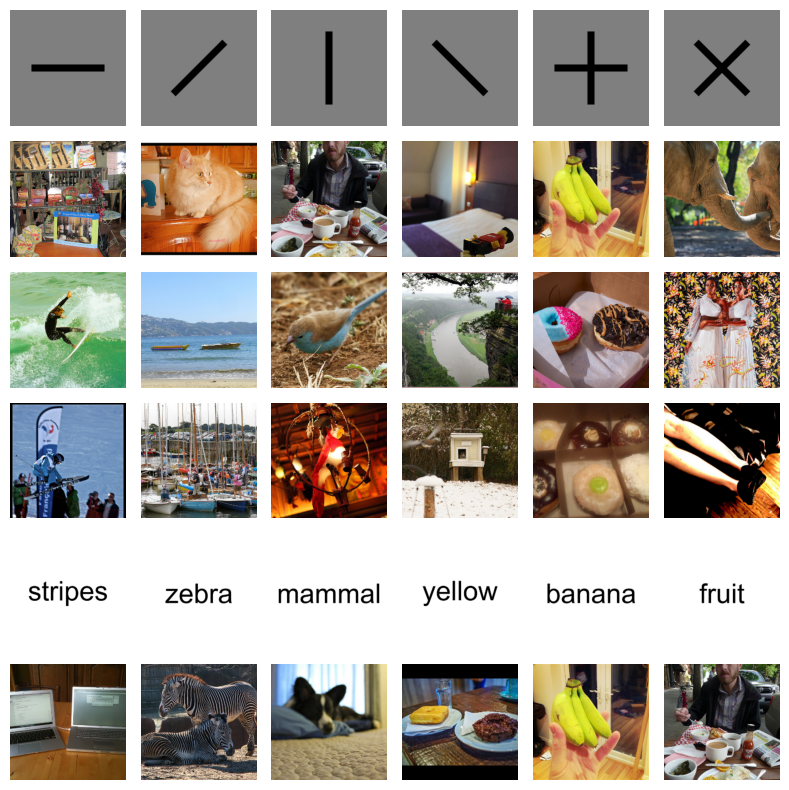

In [ ]:
# Given the brain embedding, find the nearest image embedding
print("image retrieval")
fig, axs = plt.subplots(6, 6, figsize=(8, 8))
bidx = 0
for samp_list in [np.arange(0,6),np.arange(6,12),np.arange(12,18)]:
    for cidx, brain_sample in enumerate(samp_list):
        idx = torch.argmax(cos_sims[brain_sample,:]).item()
        print(torch.max(cos_sims[brain_sample,:]))

        gt_image = utils.torch_to_Image(all_images[brain_sample])
        axs[bidx, cidx].imshow(gt_image)
        # axs[0, bidx].set_title(f"Ground Truth {brain_sample+1}")
        axs[bidx, cidx].axis('off')  # Turn off axis

        retrieved_image = all_images[idx]
        # retrieved_image = kornia.color.rgb_to_grayscale(retrieved_image).repeat(1,3,1,1)
        # retrieved_image = blur_augment(retrieved_image)
        retrieved_image = utils.torch_to_Image(retrieved_image)
        axs[bidx+1, cidx].imshow(retrieved_image)
        # axs[1, bidx].set_title(f"Retrieved {brain_sample+1}")
        axs[bidx+1, cidx].axis('off')  # Turn off axis
        
    bidx += 2
plt.tight_layout()
plt.show()

## Brain retrieval

In [ ]:
# Create cosine similarity matrix between brain embeddings and brain embeddings
num_loops = 1
from scipy import stats
cos_sims = None
emb = nn.functional.normalize(all_clipvoxels.flatten(1)).to(device)
with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
    for test_i, loop in enumerate(range(num_loops)):
        for batch in tqdm(range(0,len(all_images),18)):
            emb_ = all_clipvoxels[batch:batch+18].flatten(1) # CLIP-Brain
            emb_ = nn.functional.normalize(emb_.to(device),dim=-1)

            if cos_sims is None:
                cos_sims = emb_ @ emb.T
            else:
                cos_sims = torch.vstack((cos_sims, emb_ @ emb.T))
            break
        
assert len(cos_sims)==18
print("cos_sims", cos_sims.shape)
print(cos_sims[0,:10])

  0%|                                                     | 0/556 [00:00<?, ?it/s]

cos_sims torch.Size([18, 10000])
tensor([1.0000, 0.7808, 0.6245, 0.6753, 0.6948, 0.6631, 0.6128, 0.7681, 0.6929,
        0.7373], device='cuda:0', dtype=torch.float16)


brain retrieval
tensor(0.8057, device='cuda:0', dtype=torch.float16)
tensor(0.7920, device='cuda:0', dtype=torch.float16)
tensor(0.7925, device='cuda:0', dtype=torch.float16)
tensor(0.7734, device='cuda:0', dtype=torch.float16)
tensor(0.7993, device='cuda:0', dtype=torch.float16)
tensor(0.7539, device='cuda:0', dtype=torch.float16)
tensor(0.7925, device='cuda:0', dtype=torch.float16)
tensor(0.7925, device='cuda:0', dtype=torch.float16)
tensor(0.7637, device='cuda:0', dtype=torch.float16)
tensor(0.7852, device='cuda:0', dtype=torch.float16)
tensor(0.8257, device='cuda:0', dtype=torch.float16)
tensor(0.8140, device='cuda:0', dtype=torch.float16)
tensor(0.7886, device='cuda:0', dtype=torch.float16)
tensor(0.7734, device='cuda:0', dtype=torch.float16)
tensor(0.8042, device='cuda:0', dtype=torch.float16)
tensor(0.7778, device='cuda:0', dtype=torch.float16)
tensor(0.7803, device='cuda:0', dtype=torch.float16)
tensor(0.7891, device='cuda:0', dtype=torch.float16)


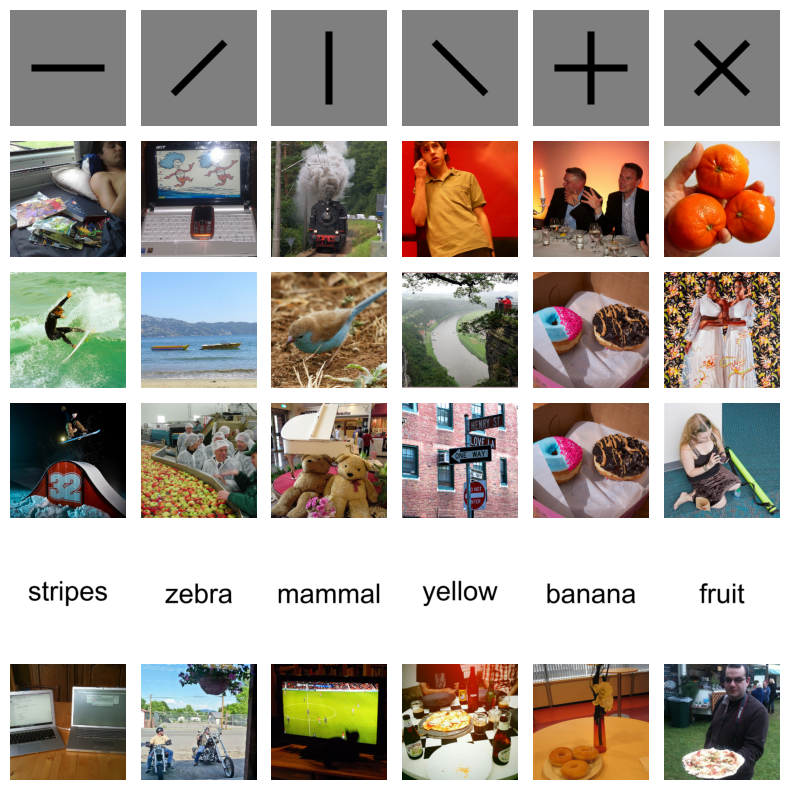

In [ ]:
# Given a brain embedding, find the nearest brain embedding in the larger pool, THEN depict the image that was presented for that brain sample
print("brain retrieval")
fig, axs = plt.subplots(6, 6, figsize=(8, 8))
bidx = 0
for samp_list in [np.arange(0,6),np.arange(6,12),np.arange(12,18)]:
    for cidx, brain_sample in enumerate(samp_list):
        idx = torch.argmax(cos_sims[brain_sample,:]).item()
        jj=-2
        while idx < 18: # disallow finding nearest neighbor brain sample from imagery dataset
            idx = torch.argsort(cos_sims[brain_sample,:])[jj].item()
            jj -= 1
        print(cos_sims[brain_sample,idx])

        gt_image = utils.torch_to_Image(all_images[brain_sample])
        axs[bidx, cidx].imshow(gt_image)
        # axs[0, bidx].set_title(f"Ground Truth {brain_sample+1}")
        axs[bidx, cidx].axis('off')  # Turn off axis

        retrieved_image = all_images[idx]
        retrieved_image = utils.torch_to_Image(retrieved_image)
        axs[bidx+1, cidx].imshow(retrieved_image)
        # axs[1, bidx].set_title(f"Retrieved {brain_sample+1}")
        axs[bidx+1, cidx].axis('off')  # Turn off axis
        
    bidx += 2
plt.tight_layout()
plt.show()

## Incorrectly labeled by Paul as brain retrieval (actually takes the ground truth image embedding and finds nearest neighbor brain sample and depicts that)

In [ ]:
emb = None
with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
    for batch in tqdm(range(0,len(all_images),minibatch_size)):
        compare_images = all_images[batch:batch+minibatch_size].to(device)

        emb0 = clip_img_embedder(compare_images)
        emb0 = nn.functional.normalize(emb0.flatten(1),dim=-1)
        
        if emb is None:
            emb = emb0
        else:
            emb = torch.vstack((emb, emb0))
emb.shape

100%|███████████████████████████████████████████| 417/417 [00:09<00:00, 45.75it/s]


torch.Size([10000, 768])

In [ ]:
num_loops = 1
from scipy import stats
cos_sims = None
with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
    for test_i, loop in enumerate(range(num_loops)):
        for batch in tqdm(range(0,len(all_images),128)):
            emb_ = all_clipvoxels[batch:batch+128].flatten(1) # CLIP-Brain
            
            emb_ = nn.functional.normalize(emb_.to(device),dim=-1)

            assert emb.shape[-1] == emb_.shape[-1]

            if cos_sims is None:
                cos_sims = emb_ @ emb.T
            else:
                cos_sims = torch.vstack((cos_sims, emb_ @ emb.T))
        
print("cos_sims", cos_sims.shape)
print(cos_sims[0,:10])

100%|███████████████████████████████████████████| 79/79 [00:00<00:00, 2916.63it/s]

cos_sims torch.Size([10000, 10000])
tensor([ 0.0101,  0.0011, -0.0043,  0.0024,  0.0011,  0.0040, -0.0180,  0.0299,
        -0.0136,  0.0033], device='cuda:0', dtype=torch.float16)


brain retrieval
tensor(0.1158, device='cuda:0', dtype=torch.float16)
tensor(0.0963, device='cuda:0', dtype=torch.float16)
tensor(0.0974, device='cuda:0', dtype=torch.float16)
tensor(0.0956, device='cuda:0', dtype=torch.float16)
tensor(0.0868, device='cuda:0', dtype=torch.float16)
tensor(0.0842, device='cuda:0', dtype=torch.float16)
tensor(0.1076, device='cuda:0', dtype=torch.float16)
tensor(0.0878, device='cuda:0', dtype=torch.float16)
tensor(0.0994, device='cuda:0', dtype=torch.float16)
tensor(0.0994, device='cuda:0', dtype=torch.float16)
tensor(0.0944, device='cuda:0', dtype=torch.float16)
tensor(0.0825, device='cuda:0', dtype=torch.float16)
tensor(0.0917, device='cuda:0', dtype=torch.float16)
tensor(0.0872, device='cuda:0', dtype=torch.float16)
tensor(0.0798, device='cuda:0', dtype=torch.float16)
tensor(0.0916, device='cuda:0', dtype=torch.float16)
tensor(0.0952, device='cuda:0', dtype=torch.float16)
tensor(0.1058, device='cuda:0', dtype=torch.float16)


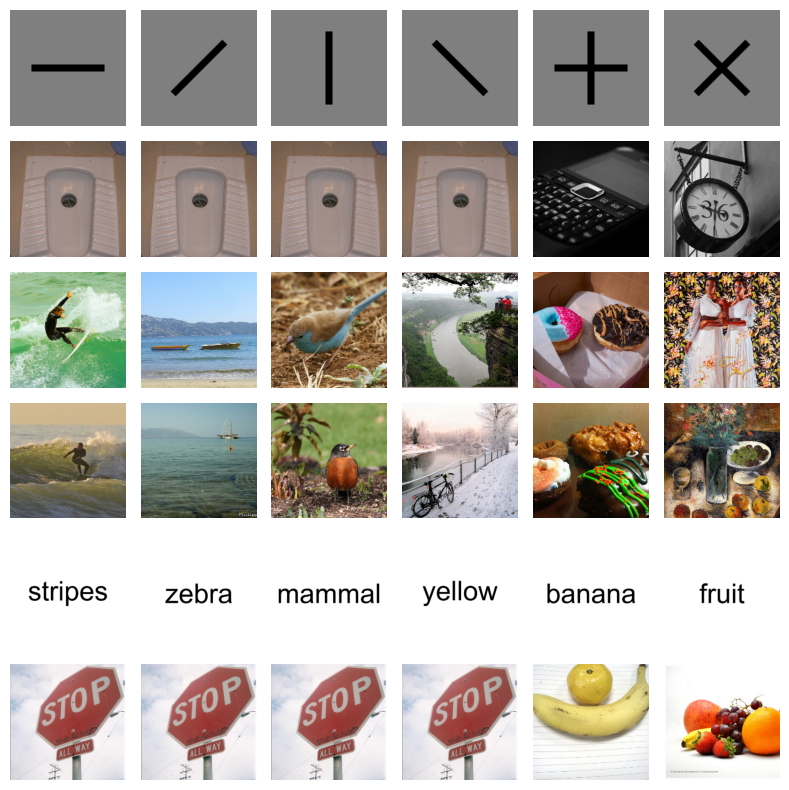

In [ ]:
print("brain retrieval")
fig, axs = plt.subplots(6, 6, figsize=(8, 8))
bidx = 0
for samp_list in [np.arange(0,6),np.arange(6,12),np.arange(12,18)]:
    for cidx, img_sample in enumerate(samp_list):
        idx = torch.argsort(cos_sims[:,img_sample])[-1].item()
        print(torch.max(cos_sims[:,img_sample]))
            
        # if torch.abs(torch.mean(all_images[idx]-all_images[img_sample])) < .00001:
        #     idx = torch.argsort(cos_sims[:,img_sample])[-2].item()
        #     print("changed idx")

        gt_image = utils.torch_to_Image(all_images[img_sample])
        axs[bidx, cidx].imshow(gt_image)
        # axs[bidx, cidx].set_title(f"Ground Truth {img_sample+1}")
        axs[bidx, cidx].axis('off')  # Turn off axis

        retrieved_image = all_images[idx]
        retrieved_image = utils.torch_to_Image(retrieved_image)
        axs[bidx+1, cidx].imshow(retrieved_image)
        # axs[bidx+1, cidx].set_title(f"Retrieved {img_sample+1}")
        axs[bidx+1, cidx].axis('off')  # Turn off axis
    bidx += 2
plt.tight_layout()
plt.show()